In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm, trange

rng = np.random.default_rng()

sns.set_style('ticks',{'axes.edgecolor': '[0,0,0]','xtick.direction':'in','ytick.direction':'in','ytick.right':'True','xtick.top':'True'})

plt.rcParams['text.usetex'] = False
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.autolayout'] = 'True'
%config Completer.use_jedi = False

In [2]:
def diffusion(size,sigma,mu):
    gamma_m = 6*np.pi*mu*0.01
    gamma = 6*np.pi*mu*0.005*size
    return ((sigma/(gamma_m+gamma))**2)/2

def Pe(r,vc):
    return np.sqrt(np.dot(vc,vc))/np.sqrt(np.dot(r-vc,r-vc))

def Sp(r,vc):
    return np.dot(r,vc)/np.sqrt(np.dot(vc,vc))

def Co(r,vc):
    return (np.dot(r,vc)/np.sqrt(np.dot(vc,vc)))/np.sqrt(np.dot(r,r))

In [3]:
def plotter(pe,sp,co,modelnamestr):
    x = np.arange(1,11)

    fig,axes = plt.subplots(1,3,figsize=(8,3))
    outputs = [pe,sp,co]
    labels = ['Pe','Sp','Co']
    flowlabel = ['wt','slow']

    for i in range(3):
        ax = axes[i]
        X = outputs[i]
        label = labels[i]

        for j in range(2):
            ax.fill_between(x = x,
                    y1 = np.mean(X[:,:,j],axis=0)-np.std(X[:,:,j],axis=0)/np.sqrt(num_cells),
                    y2 = np.mean(X[:,:,j],axis=0)+np.std(X[:,:,j],axis=0)/np.sqrt(num_cells),
                    alpha = 0.3)

            ax.errorbar(x = x,
                        y = np.mean(X[:,:,j],axis=0),
                        yerr = np.std(X[:,:,j],axis=0)/np.sqrt(num_cells),
                        label = flowlabel[j])

        ax.set_ylabel(label)
        ax.set_xticks(x)

    axes[0].legend(loc=2)
    axes[1].set_xlabel('size')
    axes[0].set_ylim(0,5)
    axes[1].set_ylim(0,0.14)
    axes[2].set_ylim(0,1)

    #ERROR BARS SHOW SEM
    fig.savefig(modelnamestr+'.pdf',format='pdf')
    
    fig,axes = plt.subplots(1,3,figsize=(8,3))
    outputs = [pe,sp,co]
    labels = ['Pe','Sp','Co']
    flowlabel = ['wt','slow']

    for i in range(3):
        ax = axes[i]
        X = outputs[i]
        label = labels[i]

        Y = (X[:,:,0] - X[:,:,1]) #fast - slow

        ax.fill_between(x = x,
                        y1 = np.mean(Y,axis=0)-np.std(Y,axis=0)/np.sqrt(num_cells),
                        y2 = np.mean(Y,axis=0)+np.std(Y,axis=0)/np.sqrt(num_cells),
                        alpha = 0.3)

        ax.errorbar(x = x,
                    y = np.mean(Y,axis=0),
                    yerr = np.std(Y,axis=0)/np.sqrt(num_cells))

        ax.set_ylabel(label)
        ax.set_xticks(x)

    axes[1].set_xlabel('size')
    axes[0].set_ylim(0,3)
    axes[1].set_ylim(0,0.12)
    axes[2].set_ylim(0,1)
    axes[1].set_title('fast - slow')
    fig.savefig(modelnamestr+'_diff.pdf',format='pdf')

    #ERROR BARS SHOW SEM of difference...? DOES THIS MAKE SENSE?

In [4]:
num_cells = 2000 #number of parameters
flowv = [-0.1,-0.05] #flow conditions


  0%|          | 0/2000 [00:00<?, ?it/s]

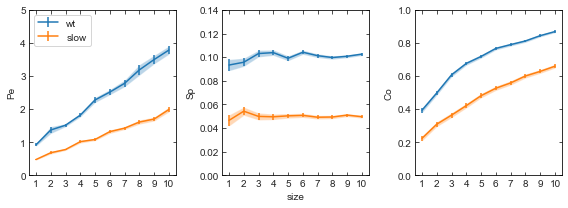

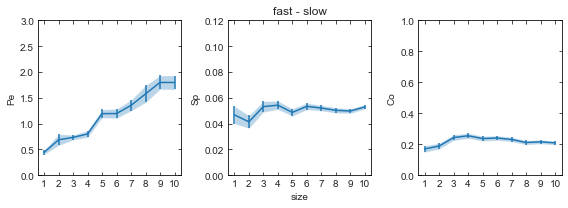

In [5]:
#MODEL 1
#get parameter sets
sigma = rng.uniform(0.005,0.02,num_cells) 
mu = rng.uniform(0.1,0.5,num_cells)

#data storage
#Dimensions: (number param sets, clustersizes 1--10, 2 flow conditions)
pe = np.empty((num_cells,10,2)) 
sp = np.empty_like(pe)
co = np.empty_like(pe)

#loop over each parameter set
for i in trange(int(num_cells)): 
    
    #for each cluster size
    for j in range(10):   
        #get diffusion coefficient
        cov = 2*diffusion(j+1,sigma[i],mu[i])*np.eye(2)
        
        #for each flow condition
        for k in range(2): 
            
            #set flow velocity
            vc = np.array([flowv[k],0]) 
            #sample from appropriate normal distn:
            v = rng.multivariate_normal(vc,cov)
            #calculate and store output
            pe[i,j,k] = Pe(v,vc)
            sp[i,j,k] = Sp(v,vc)
            co[i,j,k] = Co(v,vc)
            
plotter(pe,sp,co,'model1')

data = {'model1':{'pe':pe,'sp':sp,'co':co,'sigma':sigma,'mu':mu,'flowv':flowv}}

  0%|          | 0/2000 [00:00<?, ?it/s]

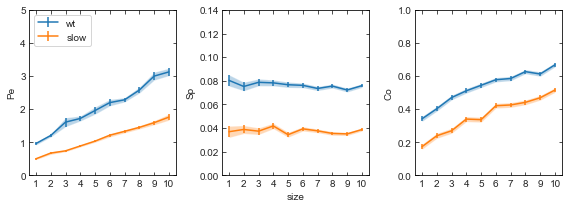

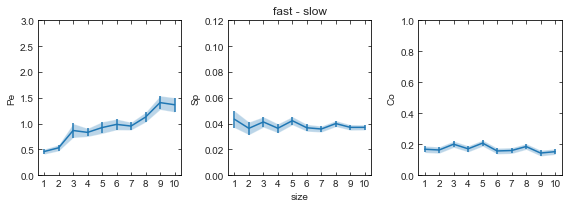

In [6]:
#MODEL 2
#get parameter sets
sigma = rng.uniform(0.005,0.02,num_cells) 
mu = rng.uniform(0.1,0.5,num_cells)
kon = rng.uniform(0.01,10,num_cells)
koff = np.ones(num_cells)

#data storage
#Dimensions: (number param sets, clustersizes 1--10, 2 flow conditions)
pe = np.empty((num_cells,10,2)) 
sp = np.empty_like(pe)
co = np.empty_like(pe)

#loop over each parameter set
for i in trange(int(num_cells)): 
    
    #for each cluster size
    for j in range(10):   
        #get diffusion coefficient
        cov = 2*diffusion(j+1,sigma[i],mu[i])*np.eye(2)
        
        #for each flow condition
        for k in range(2): 
            #set flow velocity
            vc = np.array([flowv[k],0]) 
            #determine if cluster is bound or not
            prob_bound = kon[i]/(kon[i]+koff[i])
            bound = rng.binomial(1,prob_bound)
            #sample from appropriate normal distn:
            v = rng.multivariate_normal(bound*vc,cov)
            #calculate and store output
            pe[i,j,k] = Pe(v,vc)
            sp[i,j,k] = Sp(v,vc)
            co[i,j,k] = Co(v,vc)
            
plotter(pe,sp,co,'model2')

data['model2'] = {'pe':pe,'sp':sp,'co':co,'sigma':sigma,'mu':mu,'kon':kon,'koff':koff,'flowv':flowv}

  0%|          | 0/2000 [00:00<?, ?it/s]

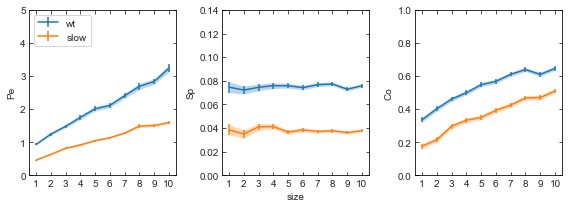

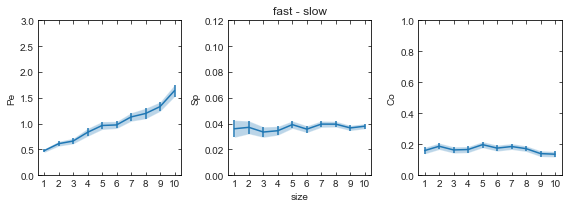

In [7]:
#MODEL 3
def konLinear(n,kon0,kon1):
    return kon0+kon1*(n-1)

#get parameter sets
sigma = rng.uniform(0.005,0.02,num_cells) 
mu = rng.uniform(0.1,0.5,num_cells)
kon = rng.uniform(0.01,10,num_cells)
kon1 = rng.uniform(0.03,0.1,num_cells)
koff = np.ones(num_cells)

#data storage
#Dimensions: (number param sets, clustersizes 1--10, 2 flow conditions)
pe = np.empty((num_cells,10,2)) 
sp = np.empty_like(pe)
co = np.empty_like(pe)

#loop over each parameter set
for i in trange(int(num_cells)): 
    
    #for each cluster size
    for j in range(10):   
        #get diffusion coefficient
        cov = 2*diffusion(j+1,sigma[i],mu[i])*np.eye(2)
        
        #for each flow condition
        for k in range(2): 
            #set flow velocity
            vc = np.array([flowv[k],0]) 
            #determine if cluster is bound or not
            prob_bound = konLinear(k+1,kon[i],kon1[i])/(konLinear(k+1,kon[i],kon1[i])+koff[i])
            bound = rng.binomial(1,prob_bound)
            #sample from appropriate normal distn:
            v = rng.multivariate_normal(bound*vc,cov)
            #calculate and store output
            pe[i,j,k] = Pe(v,vc)
            sp[i,j,k] = Sp(v,vc)
            co[i,j,k] = Co(v,vc)
            
plotter(pe,sp,co,'model3')

data['model3'] = {'pe':pe,'sp':sp,'co':co,'sigma':sigma,'mu':mu,'kon':kon,'kon1':kon1,'koff':koff,'flowv':flowv}

  0%|          | 0/2000 [00:00<?, ?it/s]

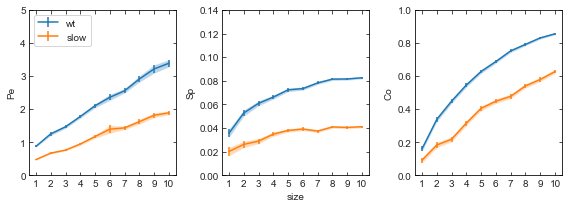

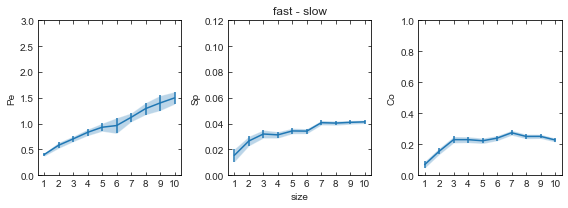

In [8]:
#MODEL 4
def diffusion_fluid_drag(n,sigma,mu):
#     sigma = 0.013
    gamma_m = 6*np.pi*0.3*0.01
    gamma = 6*np.pi*mu*0.005*n
    return ((sigma/(gamma_m+gamma))**2)/2

def velocity_fluid_drag(n,mu):
    a = 0.005*n
    gamma_m = 6*np.pi*0.3*0.01
    return (6*np.pi*mu*a)/(gamma_m + 6*np.pi*mu*a)


#get parameter sets
sigma = rng.uniform(0.005,0.02,num_cells) 
mu = rng.uniform(0.2,0.4,num_cells)

#data storage
#Dimensions: (number param sets, clustersizes 1--10, 2 flow conditions)
pe = np.empty((num_cells,10,2)) 
sp = np.empty_like(pe)
co = np.empty_like(pe)

#loop over each parameter set
for i in trange(int(num_cells)): 
    
    #for each cluster size
    for j in range(10):   
        #get diffusion coefficient
        cov = 2*diffusion_fluid_drag(j+1,sigma[i],mu[i])*np.eye(2)

        #for each flow condition
        for k in range(2): 
            #set flow velocity
            vc = np.array([flowv[k],0]) 
            mean = velocity_fluid_drag(j+1,mu[i])*vc
            #sample from appropriate normal distn:
            v = rng.multivariate_normal(mean,cov)
            #calculate and store output
            pe[i,j,k] = Pe(v,vc)
            sp[i,j,k] = Sp(v,vc)
            co[i,j,k] = Co(v,vc)
            
plotter(pe,sp,co,'model4')

data['model4'] = {'pe':pe,'sp':sp,'co':co,'sigma':sigma,'mu':mu,'flowv':flowv}

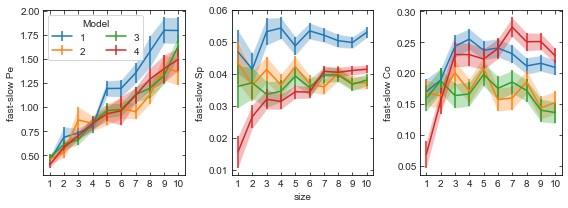

In [19]:
fig,axes = plt.subplots(1,3,figsize=(8,3))

keys = ['1','2','3','4']
x = range(1,11)
for k in range(4):
    pe = data['model'+keys[k]]['pe']
    sp = data['model'+keys[k]]['sp']
    co = data['model'+keys[k]]['co']
    
    
    outputs = [pe,sp,co]
    labels = ['Pe','Sp','Co']

    for i in range(3):
        ax = axes[i]
        X = outputs[i]
        label = labels[i]

        Y = (X[:,:,0] - X[:,:,1]) #fast - slow

        ax.fill_between(x = x,
                        y1 = np.mean(Y,axis=0)-np.std(Y,axis=0)/np.sqrt(num_cells),
                        y2 = np.mean(Y,axis=0)+np.std(Y,axis=0)/np.sqrt(num_cells),
                        alpha = 0.3)

        ax.errorbar(x = x,
                    y = np.mean(Y,axis=0),
                    yerr = np.std(Y,axis=0)/np.sqrt(num_cells),label=keys[k])

        ax.set_ylabel('fast-slow '+label)
        ax.set_xticks(x)

axes[1].set_xlabel('size')
# axes[0].set_ylim(0,3)
# axes[1].set_ylim(0,0.12)
# axes[2].set_ylim(0,1)
axes[0].legend(loc=2,title='Model',ncol=2)
fig.savefig('modelcompare.pdf',format='pdf')